<h1>What's for dinenr?</h1>
<h4><i> An simple LSTM model generates dinner suggestions from partial ingredient list </i><h4>
<h4><br></h4>
<h2>Introduction</h2>


<h2>Data Cleaning</h2>
<h3> Ingredient Data </h3>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle

import tensorflow as tf
import gensim.downloader as api
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer

import seaborn as sns
from wordcloud import WordCloud

2023-08-23 08:01:55.826642: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 08:01:55.849239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 08:01:56.223569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#precleaned dataframe will be used to clena data
precleaned_key = pd.read_pickle('ingr_map.pkl')
precleaned_key[['raw_ingr','replaced']]

,raw_ingr,replaced
0,"medium heads bibb or red leaf lettuce, washed,...",lettuce
1,mixed baby lettuces and spring greens,lettuce
2,romaine lettuce leaf,lettuce
3,iceberg lettuce leaf,lettuce
4,red romaine lettuce,lettuce
...,...,...
11654,soybeans,soybean
11655,goose,goose
11656,ajwain,ajwain
11657,brinjals,brinjal


In [3]:
cleaning_key = dict(zip(precleaned_key['raw_ingr'],precleaned_key['replaced']))

In [4]:
class CleanRecipes():
    def __init__(self,cleaning_key=cleaning_key): 
        self.raw_recipes = self.import_data()
        self.input_sequences = self.raw_recipes['ingredients'].apply(self.string_to_list).to_list()
        print(self.input_sequences)
        self.cleaned_ingredients = []
        self.cleaning_key = cleaning_key

    def __call__(self):
        self.cleaned_ingredients = self.clean_text()
        return self.raw_recipes, self.input_sequences, self.cleaned_ingredients

    def import_data(self):
        #'''Imporrhow to run a jupyter notebook in a gpu docker contqainert cleaned recipe, raw recipe and ratings data'''
        raw_recipes = pd.read_csv('RAW_recipes.csv')
        del raw_recipes['contributor_id']
        del raw_recipes['submitted']
        del raw_recipes['tags']
        del raw_recipes['steps']
        del raw_recipes['description']
        raw_recipes = raw_recipes.set_index('id')
        return raw_recipes

    def string_to_list(self,s):
        '''Converts a string that is formatted like a list to a list'''
        l = re.findall(r'\w[\w\s]+',s)
        return l

    def clean_text(self):
        #all_ingredients = [x for sublist in self.input_sequences for x in sublist]
        for recipe in self.input_sequences:
            ingredient_bundle = []
            for ingredient in recipe:
                try:
                    ingredient_bundle.append(self.cleaning_key[ingredient])
                except:
                    ingredient_bundle.append(ingredient)
            self.cleaned_ingredients.append(ingredient_bundle)
        return self.cleaned_ingredients

In [5]:
cleaner = CleanRecipes()
raw_recipes, input_sequences, cleaned_sequences = cleaner()
cleaned_sequences[1]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['pizza crust', 'sausage', 'egg', 'milk', 'salt and pepper', 'cheese']

In [6]:
#removing extra spaces
names = raw_recipes['name'].to_list()
def empty_check(s):
    if s != '':
        return True
    else: return False

cleaned_names = []
for name in names:
    cleaned_names.append(list(filter(empty_check,str(name).split(' '))))
    
print(names[:10])
cleaned_names[:10]

['arriba   baked winter squash mexican style', 'a bit different  breakfast pizza', 'all in the kitchen  chili', 'alouette  potatoes', 'amish  tomato ketchup  for canning', 'apple a day  milk shake', 'aww  marinated olives', 'backyard style  barbecued ribs', 'bananas 4 ice cream  pie', 'beat this  banana bread']


[['arriba', 'baked', 'winter', 'squash', 'mexican', 'style'],
 ['a', 'bit', 'different', 'breakfast', 'pizza'],
 ['all', 'in', 'the', 'kitchen', 'chili'],
 ['alouette', 'potatoes'],
 ['amish', 'tomato', 'ketchup', 'for', 'canning'],
 ['apple', 'a', 'day', 'milk', 'shake'],
 ['aww', 'marinated', 'olives'],
 ['backyard', 'style', 'barbecued', 'ribs'],
 ['bananas', '4', 'ice', 'cream', 'pie'],
 ['beat', 'this', 'banana', 'bread']]

<h2><br></h2>
<h2>EDA</h2>

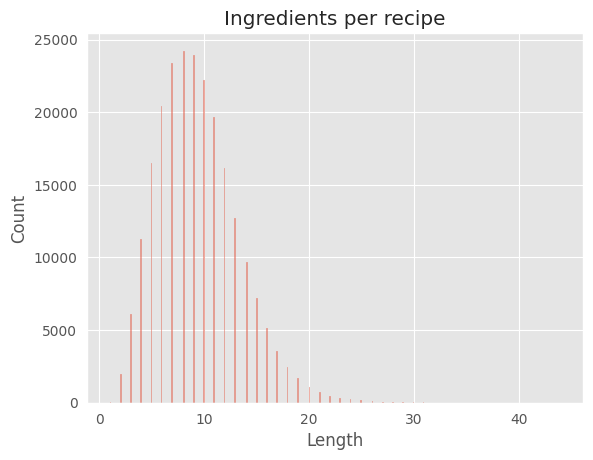

In [7]:
#ingredient list length
lengths = [len(x) for x in cleaned_sequences]
plt.style.use('ggplot')
sns.histplot(pd.DataFrame(lengths),legend=False)
plt.title('Ingredients per recipe')
plt.xlabel('Length')
plt.show()

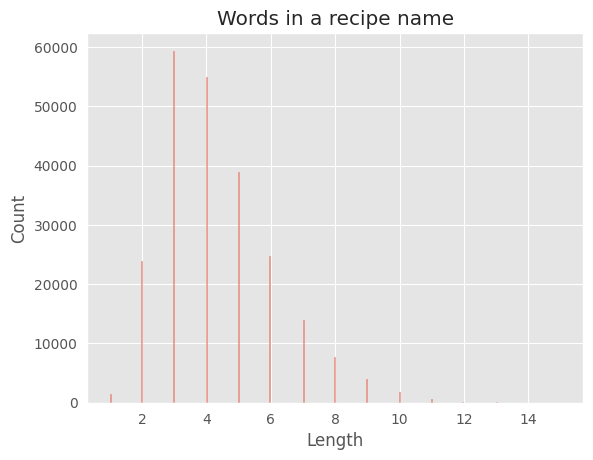

In [8]:
#Recipe name length
lengths = [len(x) for x in cleaned_names]
plt.style.use('ggplot')
sns.histplot(pd.DataFrame(lengths),legend=False)
plt.title('Words in a recipe name')
plt.xlabel('Length')
plt.show()

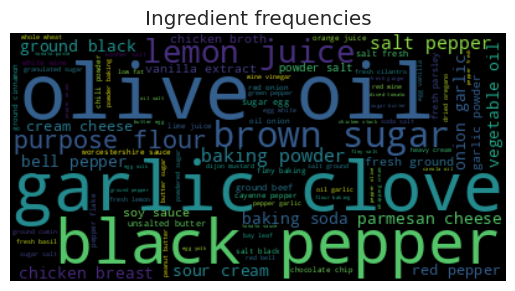

In [9]:
#overview of frequencies
all_words = ' '.join([x for sublist in cleaned_sequences for x in sublist])
wordcloud = WordCloud().generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ingredient frequencies');

In [10]:
#top words
def get_top(cleaned_sequences):
    ingred = [x for sublist in cleaned_sequences for x in sublist]
    ingred_counts = Counter(ingred).most_common()
    #top_ingredients = [ingred_counts[n][0] for n in range(len(ingred_counts))]
    return ingred_counts

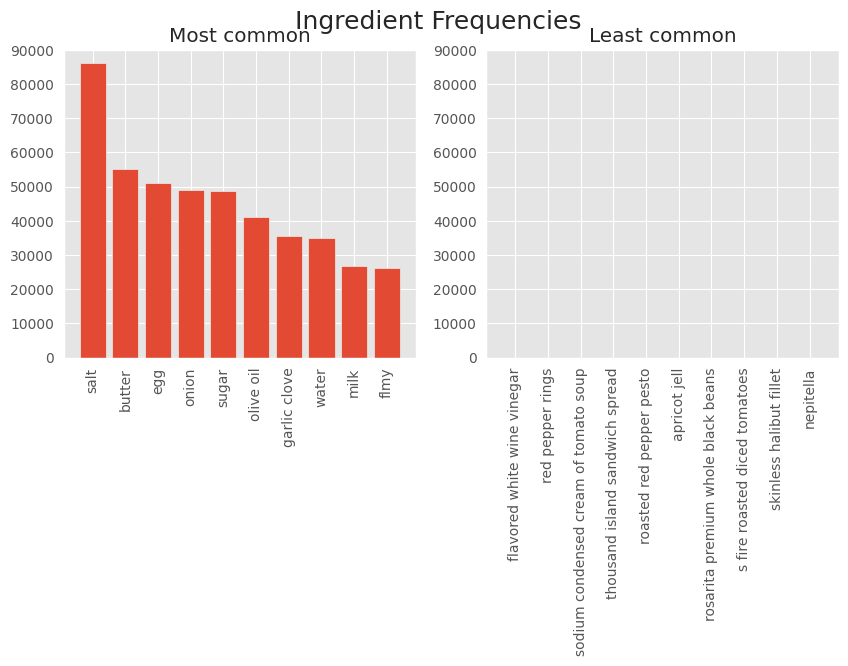

In [11]:
tops = get_top(cleaned_sequences)
sorted_ingredients = [x[0] for x in tops]
sorted_counts = [x[1] for x in tops]

count_range = 10 
plt.figure(figsize=(10,4))
plt.style.use('ggplot')
plt.suptitle('Ingredient Frequencies',fontsize=18)
plt.subplot(1,2,1)
plt.bar(sorted_ingredients[:count_range], sorted_counts[:count_range])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Most common')

plt.subplot(1,2,2)
plt.bar(sorted_ingredients[-count_range:], sorted_counts[-count_range:])
plt.xticks(rotation=90)
plt.ylim((0,90_000))
plt.title('Least common');

<h2><br></h2>
<h2>Tokenizing ingredients</h2>

In [12]:
pad_value = int(0)

In [13]:
class TokenizeRecipes():
    def __init__(self, input_sequences):
        self.tokenizer = Tokenizer()
        self.input_sequences = input_sequences
    
    def __call__(self):
        self.tokenizer, self.ngram_sequences, self.totalwords = self.get_sequence_of_tokens()
        self.max_length = self.find_max()
        self.padded_sequence = self.pad_sequences()
        self.padded_sequence = np.array(self.padded_sequence)
        self.predictors, self.label = self.padded_sequence[:,:-1],self.padded_sequence[:,-1]
        return self.tokenizer, self.max_length, self.totalwords, self.label, self.predictors

    def get_sequence_of_tokens(self):
        '''Tokenization'''    
        self.tokenizer.fit_on_texts(self.input_sequences)
        self.total_words = len(self.tokenizer.word_index) + 1

        self.ngram_sequences = []
        for line in self.input_sequences:
            token_list = self.tokenizer.texts_to_sequences([line])[0]
            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i+1]
                self.ngram_sequences.append(n_gram_sequence)
        return self.tokenizer, self.ngram_sequences, self.total_words

    def find_max(self):
        '''find max token length'''
        self.max_length = max(len(x) for x in self.input_sequences)
        return self.max_length

    def pad_sequences(self):
        '''pad sequences (built in function returns a recursion error)'''
        self.padded_sequence = []
        for sequence_in in self.ngram_sequences:
            zeros = (self.max_length-len(sequence_in))
            padded = [pad_value for zero in range(zeros)]
            padded.extend(sequence_in)
            self.padded_sequence.append(padded)
        return self.padded_sequence

In [14]:
#tokenizing ingredients
tokenizer,max_length_,total_words,label,predictors = TokenizeRecipes(cleaned_sequences)()
total_words, max_length_

(12413, 44)

Embedding words using word2vec

In [15]:
api.info(name_only=True)

{'corpora': ['semeval-2016-2017-task3-subtaskBC',
  'semeval-2016-2017-task3-subtaskA-unannotated',
  'patent-2017',
  'quora-duplicate-questions',
  'wiki-english-20171001',
  'text8',
  'fake-news',
  '20-newsgroups',
  '__testing_matrix-synopsis',
  '__testing_multipart-matrix-synopsis'],
 'models': ['fasttext-wiki-news-subwords-300',
  'conceptnet-numberbatch-17-06-300',
  'word2vec-ruscorpora-300',
  'word2vec-google-news-300',
  'glove-wiki-gigaword-50',
  'glove-wiki-gigaword-100',
  'glove-wiki-gigaword-200',
  'glove-wiki-gigaword-300',
  'glove-twitter-25',
  'glove-twitter-50',
  'glove-twitter-100',
  'glove-twitter-200',
  '__testing_word2vec-matrix-synopsis']}

In [16]:
embed_model = api.load('word2vec-google-news-300')

In [17]:
embed_size = 300

In [18]:
#tokenizing recipe name
tokenizer_name, max_length_name_, total_words_name, label_name, predictors_name = TokenizeRecipes(cleaned_names)()
total_words_name, max_length_name_

(28778, 15)

In [19]:
class EmbedWords():
    def __init__(self,cleaned_sequences, embed_size=embed_size,embed_model=embed_model, tokenizer=tokenizer):
        self.cleaned_sequences = cleaned_sequences
        self.embed_size = embed_size
        self.embed_model = embed_model
        self.word_index = tokenizer.word_index.items()
        self.unique_words = self.find_unique_word()
       
    def __call__(self):
        self.word_embeddings = self.encode_words()
        return self.unique_words, self.word_embeddings
        
    def embed_one_word(self,word):
        '''Encode a single recipe'''
        self.word_embedding = []
        try:
            self.word_embedding.append(self.embed_model[word])
        except:
            self.word_embedding.append(np.zeros((self.embed_size)))
        return self.word_embedding
    
    def find_unique_word(self):
        '''Lists unique words'''
        return list(set([x for sublist in self.cleaned_sequences for x in sublist]))
    
    def encode_words(self):
        '''Encode all recipes'''
        self.word_embeddings = np.zeros((len(self.unique_words)+1,self.embed_size))
        for word,i in self.word_index:
            self.word_embeddings[i,:] = self.embed_one_word(word)[0]
        return self.word_embeddings
    

In [20]:
#creating embeding matrices
unique_ingredients,recipe_embeddings = EmbedWords(cleaned_sequences)()
unique_names, name_embeddings = EmbedWords(cleaned_names)()

In [21]:
#shuffeling labels and predictors 
def shuffle(predictors,label):
    shuffled_index = np.random.permutation(len(predictors))
    predictors = np.array(predictors)
    label = np.array(label)
    predictors = predictors[shuffled_index]
    label = label[shuffled_index]
    predictors = tf.cast(predictors,tf.float64)
    label = tf.cast(label,tf.float64)
    return predictors, label

In [22]:
predictors, label = shuffle(predictors,label)
predictors_name, label_name = shuffle(predictors_name, label_name)

2023-08-23 08:02:34.024769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 08:02:34.038091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 08:02:34.038189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [23]:
#shape of ingredient data
predictors.shape, label.shape, recipe_embeddings.shape,len(unique_ingredients)

(TensorShape([1948345, 43]), TensorShape([1948345]), (12413, 300), 12412)

In [24]:
#shape of recipe names data
predictors_name.shape, label_name.shape, name_embeddings.shape,len(unique_names)

(TensorShape([781267, 14]), TensorShape([781267]), (28778, 300), 28777)

<h3><br></h3>
<h3>Defining model architecture</h3>

In [25]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
def create_model(LSTM_num,
                 LSTM_layers,
                 embed_size=embed_size, 
                 unique_ingredients=unique_ingredients, 
                 max_length=max_length_, 
                 recipe_embeddings=recipe_embeddings,
                 lr=0.001,
                 transfer=False,
                 mask_zero=True,
                 verbose=1):
    '''Builds LSTM model'''
    input_len = max_length-1
    ingredient_len = len(unique_ingredients)+1
    
    inputs = tf.keras.Input(shape=(input_len,))
    x = Embedding(ingredient_len, embed_size, weights=[recipe_embeddings], trainable=transfer, mask_zero=mask_zero, input_length=input_len)(inputs)
    if LSTM_layers > 1:
        for n in range(0,LSTM_layers-1):
            x = LSTM(LSTM_num, return_sequences=True)(x)
            x = Dropout(0.2)(x)
    x = LSTM(LSTM_num, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(ingredient_len, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    return model

In [36]:
def train_model(LSTM_num, 
                 LSTM_layers, 
                 predictors,label,
                 unique_words,
                 max_length, 
                 recipe_embeddings, 
                 weight_name,
                 epochs=5, 
                 mask_zero=True,
                 device='/gpu:0',
                 transfer=False,
                 lr = 0.001):
    '''Trains model with defined architecture'''
    '''Trains and fine-tunes model using cpu'''
    with tf.device(device): #run on cpu because gpu has glitch with mask_zero=True
        model = create_model(LSTM_num,
                             LSTM_layers,
                             unique_ingredients=unique_words, 
                             max_length=max_length, 
                             recipe_embeddings=recipe_embeddings,
                             mask_zero=mask_zero,
                             transfer=transfer,
                             lr=lr)
        if transfer:
            model.load_weights('training_'+weight_name+'.h5')
    
        #model.summary()
        history = model.fit(predictors, label, validation_split=.1,epochs=epochs, verbose = 1)
        return model, history

In [29]:
#architecture grid search
nums = [20, 100, 200, 500, 1000]
num_history = []
legend_label = []
for num in nums:
    for layer in range(1,4):
        #print(' ')
        #print(f'LSTM number = {num}')
        #print(f'LSTM layers = {layer}')
        legend_label.append(f'Layers: {layer}, LSTMs: {num}')
        _, history = train_model(num,layer,predictors[:1000], label[:1000],unique_ingredients,max_length_, recipe_embeddings, 'num_weights',epochs=5, mask_zero=False)
        num_history.append(history)

Epoch 1/5


2023-08-23 08:02:50.008885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-23 08:02:50.020039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-23 08:02:50.032243: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efe953341e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-23 08:02:50.032266: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-08-23 08:02:50.034984: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-23 08:02:50.102033: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

29/29 [==============================] - 1s 8ms/step - loss: 9.4040 - val_loss: 9.3245
Epoch 2/5
29/29 [==============================] - 0s 3ms/step - loss: 8.9307 - val_loss: 8.6004
Epoch 3/5
29/29 [==============================] - 0s 3ms/step - loss: 7.8300 - val_loss: 7.8612
Epoch 4/5
29/29 [==============================] - 0s 3ms/step - loss: 6.8788 - val_loss: 7.3965
Epoch 5/5
29/29 [==============================] - 0s 2ms/step - loss: 6.2991 - val_loss: 7.1792
Epoch 1/5
29/29 [==============================] - 1s 12ms/step - loss: 9.3988 - val_loss: 9.2869
Epoch 2/5
29/29 [==============================] - 0s 3ms/step - loss: 8.8620 - val_loss: 8.5466
Epoch 3/5
29/29 [==============================] - 0s 4ms/step - loss: 7.7587 - val_loss: 7.7962
Epoch 4/5
29/29 [==============================] - 0s 3ms/step - loss: 6.8288 - val_loss: 7.3734
Epoch 5/5
29/29 [==============================] - 0s 3ms/step - loss: 6.2938 - val_loss: 7.1856
Epoch 1/5
29/29 [======================

KeyboardInterrupt: 

In [30]:
with open('num_history.pkl','wb') as f:
    pickle.dump([num_history, legend_label],f)
f.close()

In [31]:
def plot_history(history, legend, show_train=True, show_valid=True):
    '''Plots single history'''
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    epochs_train = len(loss)
    plt.style.use('ggplot')
    #plt.figure(figsize=(8, 4))   
    if show_train:
        plt.plot(range(1,epochs_train+1), pd.DataFrame(loss), label=('Training - '+str(legend)))
    if show_valid:
        plt.plot(range(1,epochs_train+1), pd.DataFrame(val_loss), label=('Validation - '+str(legend)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

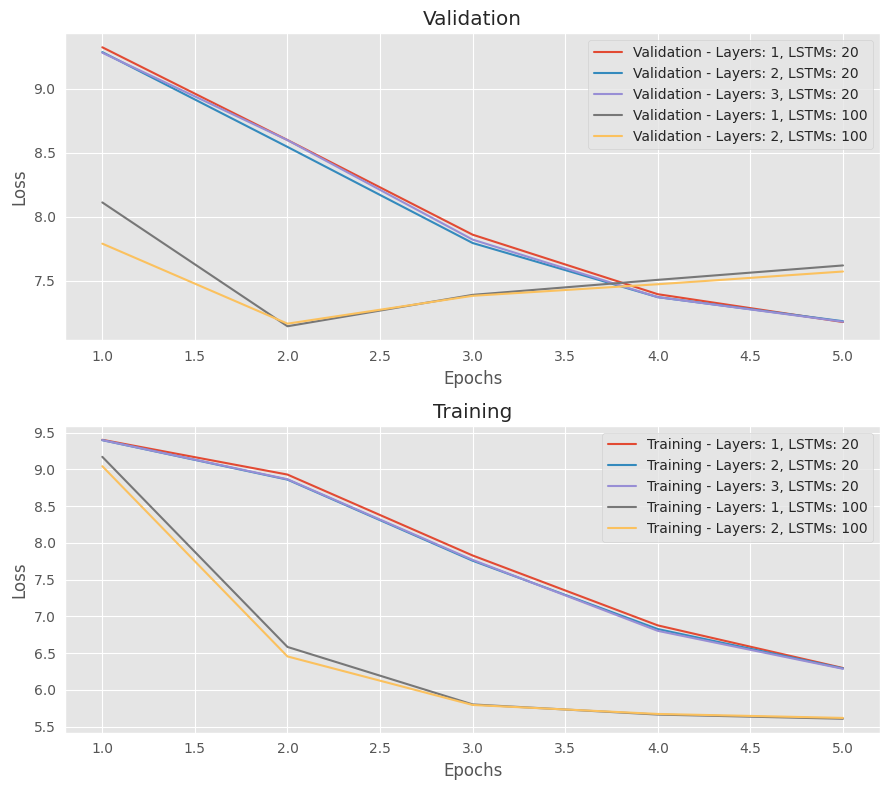

In [32]:
#show training results from different architecutres
plt.figure(figsize=(9,8))
for n,history in enumerate(num_history):
    plt.subplot(2,1,1)
    plt.title('Validation')
    plot_history(history,legend_label[n], show_train=False)
    plt.legend(bbox_to_anchor=(1,1))
    plt.subplot(2,1,2)
    plt.title('Training')
    plot_history(history,legend_label[n], show_valid=False)
    plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()

In [33]:
LSTM_ = 1000
layers_ = 2

In [34]:
def train_and_ft(predictors,label,unique_ingredients,max_length, recipe_embeddings,weight_name):
    '''Trains and fine tunes LSTM model'''
    #train LSTM and dense layer
    model, history = train_model(LSTM_, layers_, 
                                predictors[:1_000],
                                label[:1_000],
                                unique_ingredients,
                                max_length,
                                recipe_embeddings,
                                weight_name,
                                mask_zero=False,
                                device='/gpu:0')
    model.save_weights('training_'+weight_name+'.h5')
    
    #fine tune all layers
    model, fine_history = train_model(LSTM_, layers_, 
                                predictors[:1_000],
                                label[:1_000],
                                unique_ingredients,
                                max_length,
                                recipe_embeddings,
                                weight_name,
                                mask_zero=False,
                                device='/gpu:0',
                                transfer=True,
                                lr = 0.0001)
    model.save_weights('fine_'+weight_name+'.h5')
    return model, history, fine_history

In [38]:
model, history, fine_history = train_and_ft(predictors,label,unique_ingredients,max_length_,recipe_embeddings,'weight')

Epoch 1/5
29/29 [==============================] - 2s 41ms/step - loss: 7.9499 - val_loss: 7.2508
Epoch 2/5
29/29 [==============================] - 1s 33ms/step - loss: 6.0232 - val_loss: 7.2617
Epoch 3/5
29/29 [==============================] - 1s 34ms/step - loss: 5.7508 - val_loss: 7.4316
Epoch 4/5
29/29 [==============================] - 1s 34ms/step - loss: 5.6638 - val_loss: 7.8215
Epoch 5/5
29/29 [==============================] - 1s 35ms/step - loss: 5.6419 - val_loss: 7.8943
<keras.src.engine.functional.Functional object at 0x7efeec44e1a0> <keras.src.callbacks.History object at 0x7efeec5f63e0>
Epoch 1/5
29/29 [==============================] - 3s 80ms/step - loss: 5.5406 - val_loss: 7.9137
Epoch 2/5
29/29 [==============================] - 2s 57ms/step - loss: 5.5069 - val_loss: 7.9783
Epoch 3/5
29/29 [==============================] - 1s 51ms/step - loss: 5.4962 - val_loss: 8.0448
Epoch 4/5
29/29 [==============================] - 2s 52ms/step - loss: 5.4958 - val_loss: 8.11

In [37]:
name_model, name_history, name_fine_history = train_and_ft(predictors_name,label_name,unique_names,max_length_name_, name_embeddings,'name_weight')

Epoch 1/5
29/29 [==============================] - 2s 28ms/step - loss: 9.1511 - val_loss: 8.7105
Epoch 2/5
29/29 [==============================] - 1s 20ms/step - loss: 6.6702 - val_loss: 8.5818
Epoch 3/5
29/29 [==============================] - 1s 20ms/step - loss: 6.1458 - val_loss: 8.7838
Epoch 4/5
29/29 [==============================] - 1s 20ms/step - loss: 6.0257 - val_loss: 8.9584
Epoch 5/5
29/29 [==============================] - 1s 20ms/step - loss: 5.9983 - val_loss: 8.9869
<keras.src.engine.functional.Functional object at 0x7eff11f8b580> <keras.src.callbacks.History object at 0x7eff11e3c910>
Epoch 1/5
29/29 [==============================] - 3s 81ms/step - loss: 5.8013 - val_loss: 8.9787
Epoch 2/5
29/29 [==============================] - 1s 42ms/step - loss: 5.7630 - val_loss: 9.0846
Epoch 3/5
29/29 [==============================] - 1s 35ms/step - loss: 5.7364 - val_loss: 9.1961
Epoch 4/5
29/29 [==============================] - 1s 23ms/step - loss: 5.7328 - val_loss: 9.29

In [44]:
with open('histories.pkl','wb') as f:
    pickle.dump([model, history.history, fine_history.history],f)
f.close()

with open('name_histories.pkl','wb') as f:
    pickle.dump([name_model, name_history.history, name_fine_history.history],f)
f.close()

NameError: name 'name_model' is not defined

In [45]:
with open('histories.pkl','rb') as f:
    _ = pickle.load(f)
    history = _[0]
    fine_history = _[1]
    model = _[3]
f.close()

IndexError: list index out of range

In [ ]:
def plot_history(history_, fine_history_):
    epochs_train = len(history_['loss'])
    history_['loss'].extend(fine_history_['loss'])
    history_['val_loss'].extend(fine_history_['val_loss'])
    epochs_ft = len(history_['loss'])
    print(len(history_['loss']),epochs_ft)
 
    count = 1
    plt.style.use('ggplot')
    plt.title('Ingredient prediction')
    plt.figure(figsize=(8, 4))   
    plt.plot(range(1,epochs_ft+1), pd.DataFrame(history_['loss']), label='Training Loss')
    plt.plot(range(1,epochs_ft+1), pd.DataFrame(history_['val_loss']), label='Validation Loss')
    plt.legend()
    plt.text(4,5.45,'Training')
    plt.text(12,4.85,'Fine tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
plot_history(history,fine_history)

In [ ]:
plot_history(history_name,fine_history_name)

<h2><br></h2>
<h2>Predicting what's for dinner</h2>

In [ ]:
def pad_sequences(token_list, max_length=max_length):
    '''pad sequences (built in function returns a recursion error)'''
    padded_sequence = []
    zeros = (max_length-len(token_list))-1
    padded = [int(0) for zero in range(zeros)]
    padded.extend(token_list)
    return padded

In [ ]:
def cook_for_me(seed_text, model):
    next_words = 5
    words_out = []
    token_list = []

    seed_text = seed_text.split(' ')
    for word in seed_text:
        token_ = tokenizer.texts_to_sequences([word])[0]
        token_list.extend(token_)
    token_list = pad_sequences(token_list)
        
    while next_words > 0:
        model.load_weights('weights.h5')
        proba = model.predict(np.array(token_list).reshape(-1,43), verbose=0)
        predicted = np.argmax(proba, axis=1)
        new_token = int(predicted[0])
        word = list(tokenizer.word_index.keys())[int(predicted[0]-1)]
        words_out.append(word)
        token_list.append(new_token)
        token_list.pop(0)
        next_words -= 1
    words_out = list(set(words_out))
    string_out = 'Why not try adding some '+', '.join(words_out[:-1])+' and '+words_out[-1]+'?'
    return string_out

In [ ]:
list_out = ['mirin','sesame oil', 'garlic clove', 'soy sauce', 'sugar', 'fresh ginger']
list_out_ = ['chocolate','flour','backing soda','eggs','butter']
list_out__ = ['pineapple','sugar','cherry']

def name_recipe(list_out,weights='name_weights.h5',next_words=4):
    token_list = []
    for word in list_out:
        token_ = tokenizer.texts_to_sequences([word])[0]
        token_list.extend(token_)
    token_list = pad_sequences(token_list)[-14:]
    name_model.load_weights(weights)
    
    words_out=[]
    while next_words > 0:
        proba = name_model.predict(np.array(token_list).reshape(-1,14), verbose=0)
        predicted = np.argmax(proba, axis=1)
        new_token = int(predicted[0])
        word = list(tokenizer_name.word_index.keys())[int(predicted[0]-1)]
        words_out.append(word)
        token_list.append(new_token)
        token_list.pop(0)
        next_words -= 1
    text_out = str(list_out[0].split(' ')[-1])+' '+' '.join(words_out)

    print(text_out)
    
name_recipe(list_out__)

In [ ]:
def make_suggestions(ingredients_in_stock):
    for ingredient in ingredients_in_stock:
        split_ingredients = ' and '.join(ingredient.split(' '))
        greeting = 'For '+split_ingredients.upper() +' let me see... '
        print(greeting)
        print(cook_for_me(ingredient,model))
        print('')

In [ ]:
ingredients_in_stock = ['tuna','chicken noodle','mirin','cherry','chocolate flour','lettuce']
make_suggestions(ingredients_in_stock)